In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv')
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [3]:
df.shape

(169909, 19)

## Helper Functions

In [4]:
def normalize(df):
    # Normalize numerical columns
    columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
    for feature in columns:
        max_val = df[feature].max()
        min_val = df[feature].min()
        df[feature] = (df[feature] - min_val) / (max_val - min_val)

    return df

In [5]:
def data_preprocessing(df):
    # df['release_date'] = pd.to_datetime(df['release_date'], format='mixed')
    df = df[df['year'] > 1970]
    df['year'] = pd.to_datetime(df['year'], format='%Y')
    df = df.sort_values(by='year')
    df.dropna(inplace=True)

    df = normalize(df)

    return df

In [6]:
def train_test_split(df):
    cutoff_date = '2000-01-01'

    # Split the dataframe
    train = df.loc[:cutoff_date]
    test = df.loc[cutoff_date:]

    train = train.resample('Y').mean()
    test = test.resample('Y').mean()

    train.dropna(inplace=True)
    test.dropna(inplace=True)

    return train, test

## Data Proprocessing and EDA

In [7]:
df = data_preprocessing(df)
df.shape

/var/folders/vn/x9qk0byj0yn57z3dltd2nxf80000gn/T/ipykernel_35776/2352358268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = pd.to_datetime(df['year'], format='%Y')


(99656, 19)

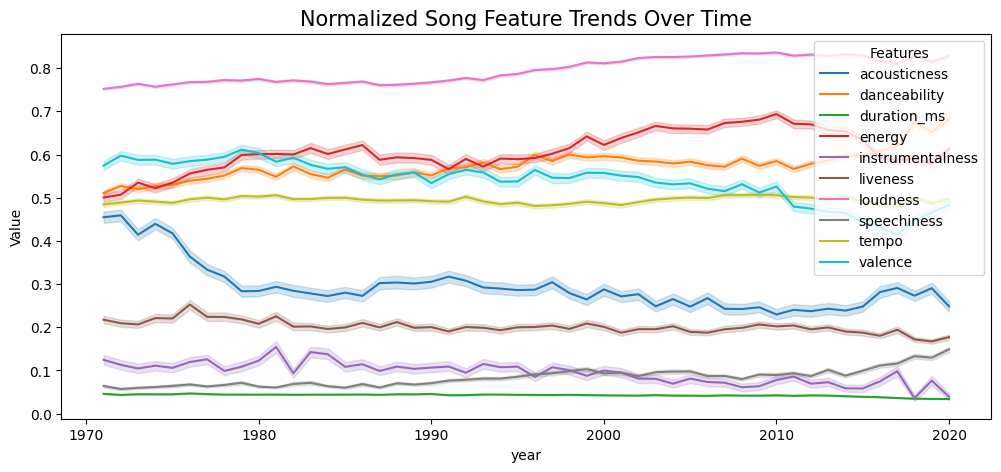

In [8]:
# Create a simple line plot for initial analysis
plt.figure(figsize=(12,5))
plt.title("Normalized Song Feature Trends Over Time", fontdict={"fontsize": 15})

lines = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

for line in lines:
    sns.lineplot(x='year', y=line, data=df, label=line)
    
plt.ylabel("Value")
plt.legend(title="Features")
plt.show()

In [9]:
# Popular songs data
popular_df = df[df['popularity'] >= 50]
popular_df.shape

(36993, 19)

In [10]:
# Unpopular songs data
unpopular_df = df[df['popularity'] < 50]
unpopular_df.shape

(62663, 19)

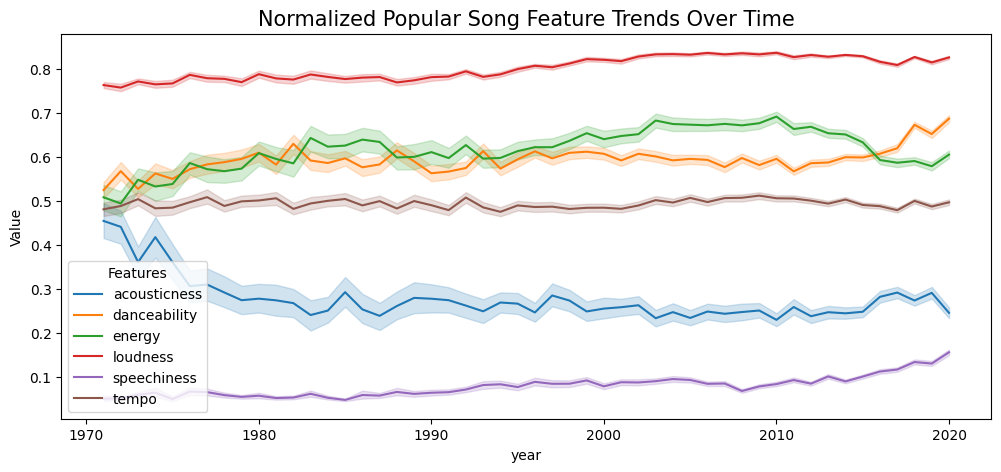

In [49]:
# Visualize popular songs df feature trends over time
plt.figure(figsize=(12, 5))
plt.title("Normalized Popular Song Feature Trends Over Time", fontdict={"fontsize": 15})

lines = ['acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'tempo']

for line in lines:
    sns.lineplot(x='year', y=line, data=popular_df, label=line)
    
plt.ylabel("Value")
plt.legend(title="Features")
plt.show()

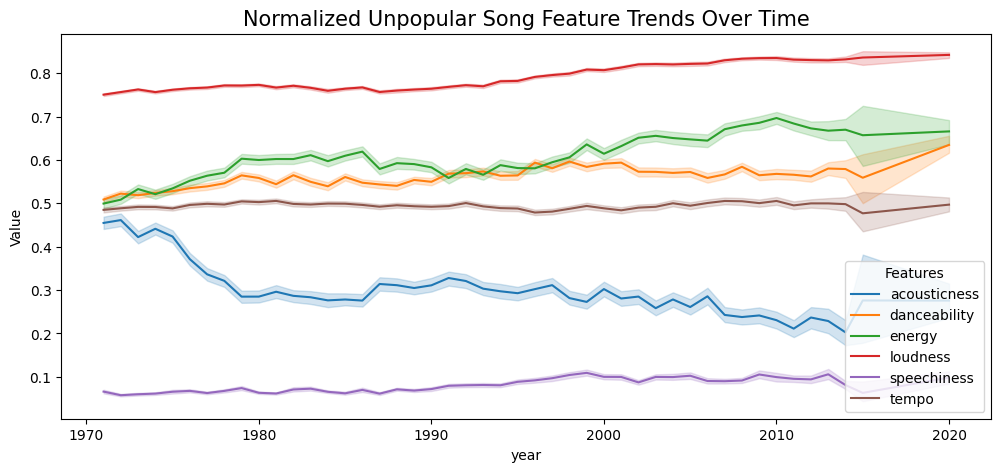

In [50]:
# Visualize unpopular songs df feature trends over time
plt.figure(figsize=(12, 5))
plt.title("Normalized Unpopular Song Feature Trends Over Time", fontdict={"fontsize": 15})

lines = ['acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'tempo']

for line in lines:
    sns.lineplot(x='year', y=line, data=unpopular_df, label=line)
    
plt.ylabel("Value")
plt.legend(title="Features")
plt.show()

There is clearly a difference between popular and unpopular song features over time. Before the 1970s, popular songs had more variations in the six features: acousticness, danceability, energy, loudness, speechiness, and tempo. On the other hand, unpopular songs had less variation, indicating that their style stay relatively stagnant. After thr 1970s, both unpopular and popular songs' features become relatively stable over time.

We want to predict future popular songs' feature trends.

In [12]:
df_popular = popular_df[['year', 'acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'tempo', 'popularity']]
df_unpopular = unpopular_df[['year', 'acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'tempo', 'popularity']]

In [13]:
df_popular['year'] = pd.to_datetime(df_popular['year'], format='%Y')
df_unpopular['year'] = pd.to_datetime(df_unpopular['year'], format='%Y')

# Set 'year' as the index
df_popular.set_index('year', inplace=True)
df_unpopular.set_index('year', inplace=True)

/var/folders/vn/x9qk0byj0yn57z3dltd2nxf80000gn/T/ipykernel_35776/2827517493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popular['year'] = pd.to_datetime(df_popular['year'], format='%Y')
/var/folders/vn/x9qk0byj0yn57z3dltd2nxf80000gn/T/ipykernel_35776/2827517493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unpopular['year'] = pd.to_datetime(df_unpopular['year'], format='%Y')


## Baseline ARIMA

In [51]:
acous_df = df_popular['acousticness']
acous_df = acous_df.resample('Y').mean()
acous_df.head()

/var/folders/vn/x9qk0byj0yn57z3dltd2nxf80000gn/T/ipykernel_35776/2082910502.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  acous_df = acous_df.resample('Y').mean()


year
1971-12-31    0.454244
1972-12-31    0.440739
1973-12-31    0.360485
1974-12-31    0.417329
1975-12-31    0.360256
Freq: YE-DEC, Name: acousticness, dtype: float64

In [52]:
acous_df.dropna(inplace=True)

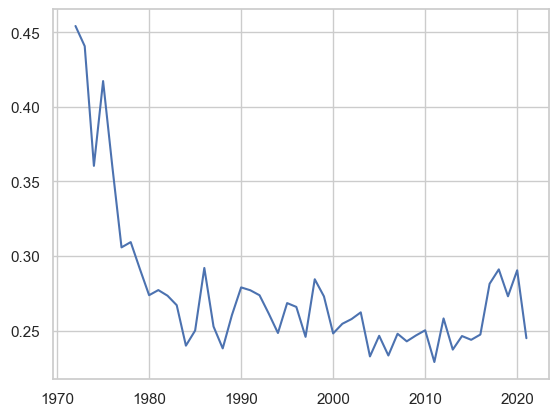

In [53]:
plt.plot(acous_df)

In [54]:
train, test = train_test_split(acous_df)

/var/folders/vn/x9qk0byj0yn57z3dltd2nxf80000gn/T/ipykernel_35776/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/vn/x9qk0byj0yn57z3dltd2nxf80000gn/T/ipykernel_35776/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


In [55]:
# Test if the process is stationary
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -3.9025049864467585
p-value: 0.002016488933801687


Since the p-value is less than 0.05, this process is stationary. We don't need differencing in the ARIMA model.

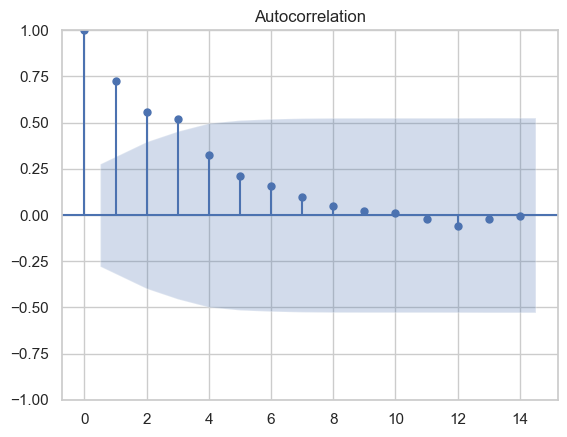

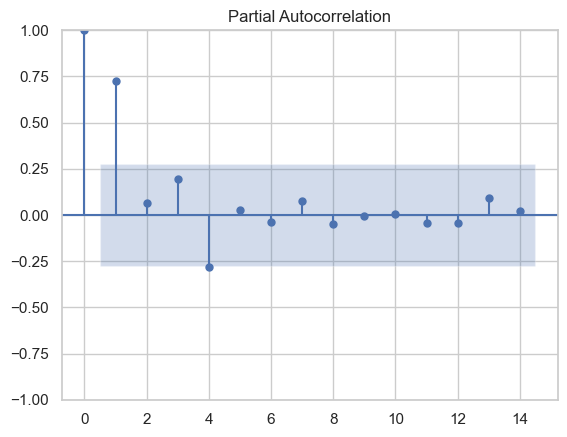

In [56]:
# ACF and PACF plots to determine p and q

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
plot_acf(acous_df, lags=np.floor(len(train)/2))
plot_pacf(acous_df, lags=np.floor(len(train)/2))
plt.show()

In [57]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = ARIMA(train, order=(2, 0, 3))
# model = SARIMAX(train, order=(2, 0, 3), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# Print summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           acousticness   No. Observations:                   29
Model:                 ARIMA(2, 0, 3)   Log Likelihood                  65.575
Date:                Mon, 25 Nov 2024   AIC                           -117.150
Time:                        15:15:06   BIC                           -107.579
Sample:                    12-31-1971   HQIC                          -114.153
                         - 12-31-1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3230      0.061      5.308      0.000       0.204       0.442
ar.L1          0.9002      0.287      3.140      0.002       0.338       1.462
ar.L2          0.0039      0.308      0.013      0.9

/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [58]:
import itertools
from sklearn.metrics import mean_squared_error

# Define a range of values for p and q
p = q = range(0, 4)  # Test values from 0 to 3
d = 0  # Since the series is stationary
pdq = list(itertools.product(p, [d], q))

# Grid search to find the best combination of p, d, q
best_aic = float("inf")
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(acous_df, order=order)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model = model_fit
    except:
        continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")


/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/stat

Best ARIMA order: (2, 0, 3) with AIC: -220.52595730453055


/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-pack

RMSE: 0.01943695735525726


/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


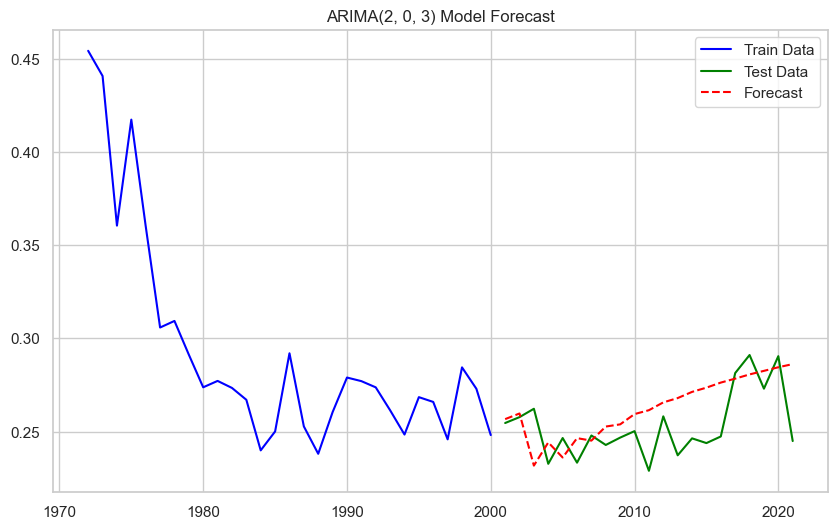

In [59]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate RMSE
rmse = mean_squared_error(test, forecast, squared=False)
print(f'RMSE: {rmse}')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train Data', color='blue')
plt.plot(test, label='Test Data', color='green')
plt.plot(test.index, forecast, label='Forecast', linestyle='--', color='red')
plt.title('ARIMA(2, 0, 3) Model Forecast')
plt.legend()
plt.show()


/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 0.01943695735525726


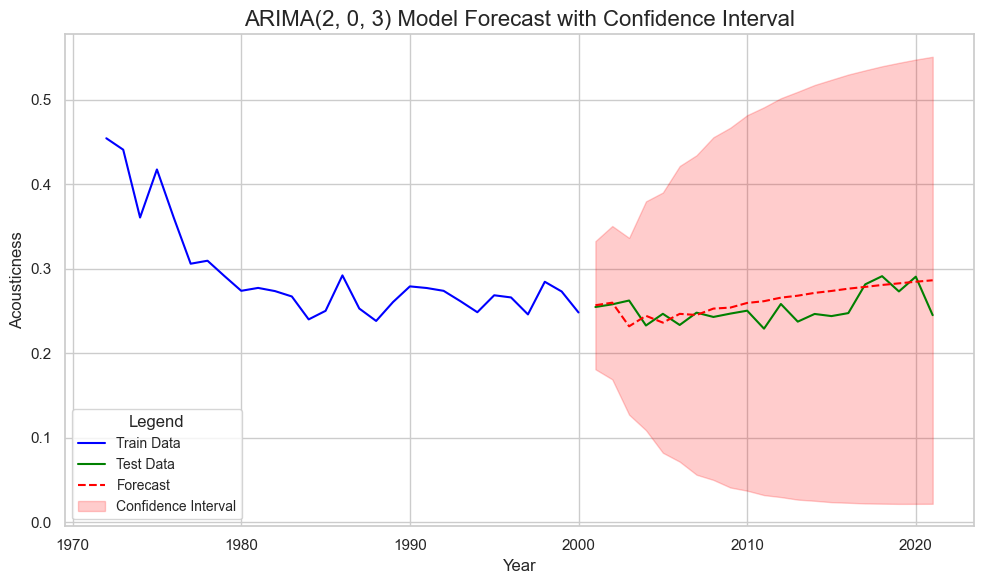

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Forecast and confidence intervals
forecast = model_fit.forecast(steps=len(test))
forecast = forecast.flatten() if forecast.ndim > 1 else forecast  # Ensure 1D

# Get confidence intervals
conf_int = model_fit.get_forecast(steps=len(test)).conf_int(alpha=0.001)

# Evaluate RMSE
rmse = mean_squared_error(test, forecast, squared=False)
print(f'RMSE: {rmse}')

# Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot train data
sns.lineplot(x=train.index, y=train.values, label='Train Data', color='blue')

# Plot test data
sns.lineplot(x=test.index, y=test.values, label='Test Data', color='green')

# Plot forecast
sns.lineplot(x=test.index, y=forecast, label='Forecast', color='red', linestyle='--')

# Add confidence intervals as shaded regions
plt.fill_between(
    test.index,
    conf_int['lower acousticness'],
    conf_int['upper acousticness'],
    color="red",
    alpha=0.2,
    label="Confidence Interval",
)

# Add titles and labels
plt.title('ARIMA(2, 0, 3) Model Forecast with Confidence Interval', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Acousticness', fontsize=12)
plt.legend(title="Legend", fontsize=10)
plt.tight_layout()
plt.show()


In [66]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

def time_series_analysis(train, test):
    """
    Performs ARIMA time series analysis, including model selection, fitting, and forecasting.

    Parameters:
        train (pd.DataFrame): The training dataset (time series).
        test (pd.DataFrame): The testing dataset (time series).

    Returns:
        dict: A dictionary containing the best model, forecast, RMSE, and plots.
    """
    # ADF Test for stationarity
    adf_result = adfuller(train)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])

    # ACF and PACF plots
    plt.figure(figsize=(12, 6))
    plot_acf(train, lags=min(40, len(train)//2))
    plot_pacf(train, lags=min(40, len(train)//2))
    plt.show()

    # Grid search for best ARIMA parameters
    p = q = range(0, 4)
    d = 0  # Assumed stationary
    pdq = list(itertools.product(p, [d], q))

    best_aic = float("inf")
    best_order = None
    best_model = None

    for order in pdq:
        try:
            model = ARIMA(train, order=order)
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = order
                best_model = model_fit
        except:
            continue

    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

    # Forecast using the best model
    forecast = best_model.forecast(steps=len(test))
    forecast = forecast.flatten() if forecast.ndim > 1 else forecast

    # Get confidence intervals
    conf_int = best_model.get_forecast(steps=len(test)).conf_int()

    # Evaluate RMSE
    rmse = mean_squared_error(test, forecast, squared=False)
    # print(f'RMSE: {rmse}')

    # Plot the results
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(x=train.index, y=train.values, label='Train Data', color='blue')
    sns.lineplot(x=test.index, y=test.values, label='Test Data', color='green')
    sns.lineplot(x=test.index, y=forecast, label='Forecast', color='red', linestyle='--')

    plt.fill_between(
        test.index,
        conf_int.iloc[:, 0],
        conf_int.iloc[:, 1],
        color="red",
        alpha=0.2,
        label="Confidence Interval",
    )

    plt.title('ARIMA Model Forecast with Confidence Interval', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(title="Legend", fontsize=10)
    plt.tight_layout()
    plt.show()

    # return {
    #     "best_model": best_model,
    #     "forecast": forecast,
    #     "rmse": rmse,
    #     "confidence_interval": conf_int
    # }


ADF Statistic: -3.9025049864467585
p-value: 0.002016488933801687


<Figure size 1200x600 with 0 Axes>

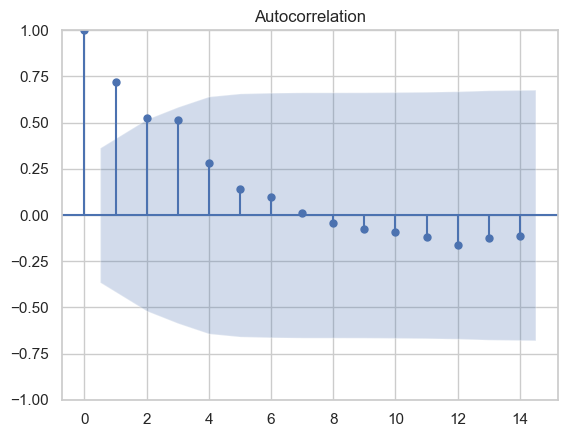

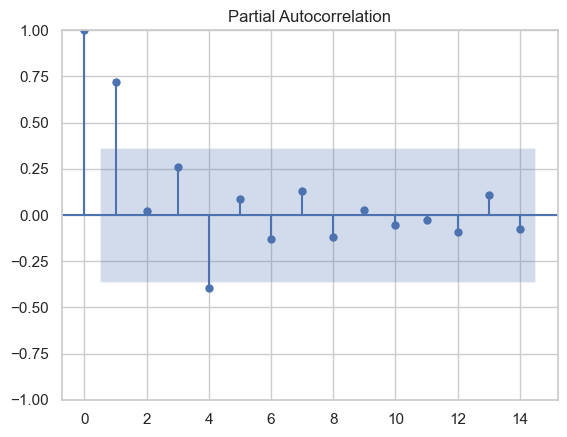

/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/tsa/state

Best ARIMA order: (1, 0, 3) with AIC: -119.19364312095371


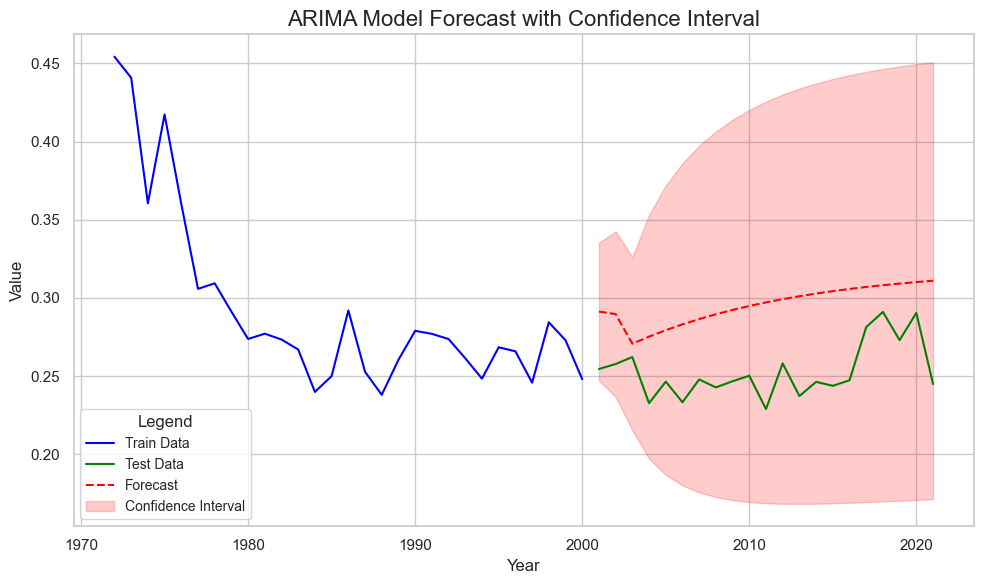

In [67]:
time_series_analysis(train, test)

In [68]:
energy_df = df_popular['energy']
energy_df = energy_df.resample('Y').mean()
energy_df.head()

/var/folders/vn/x9qk0byj0yn57z3dltd2nxf80000gn/T/ipykernel_35776/2187345849.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  energy_df = energy_df.resample('Y').mean()


year
1971-12-31    0.508010
1972-12-31    0.493979
1973-12-31    0.548034
1974-12-31    0.532608
1975-12-31    0.538312
Freq: YE-DEC, Name: energy, dtype: float64

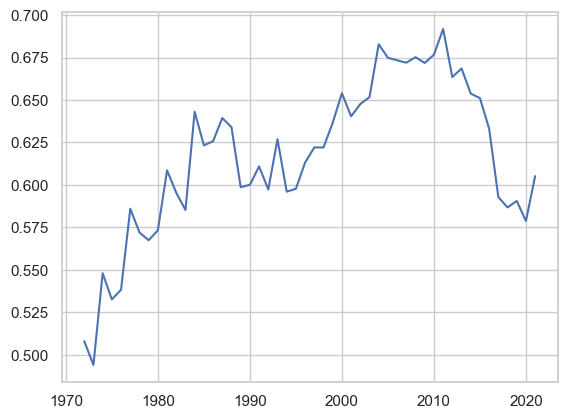

In [69]:
plt.plot(energy_df)

In [70]:
energy_train, energy_test = train_test_split(energy_df)

/var/folders/vn/x9qk0byj0yn57z3dltd2nxf80000gn/T/ipykernel_35776/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/vn/x9qk0byj0yn57z3dltd2nxf80000gn/T/ipykernel_35776/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


ADF Statistic: -2.116994102994834
p-value: 0.2377363199348057


<Figure size 1200x600 with 0 Axes>

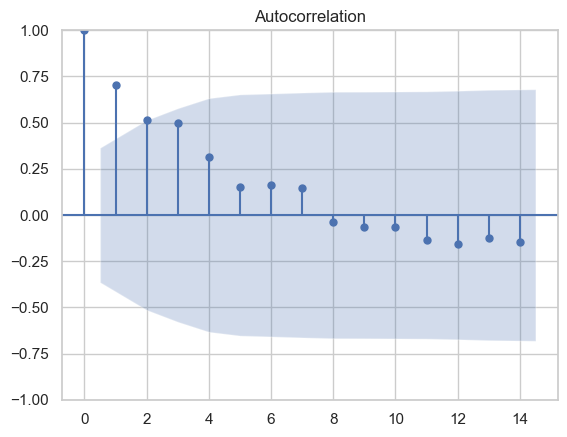

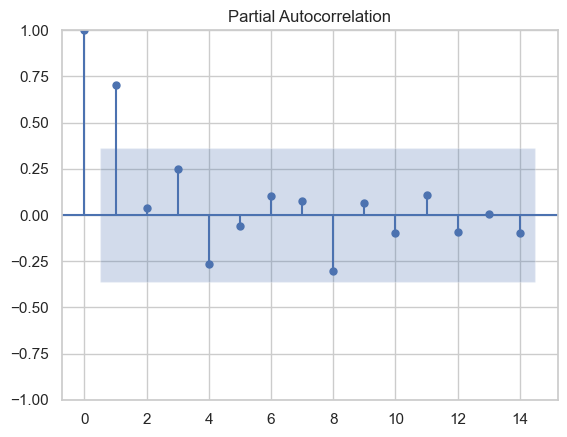

/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amytang10/Desktop/1018_Time_Series/1018_time_series_project/ts_project/lib/python3.9/site-packages/stat

Best ARIMA order: (1, 0, 3) with AIC: -131.80135901908287


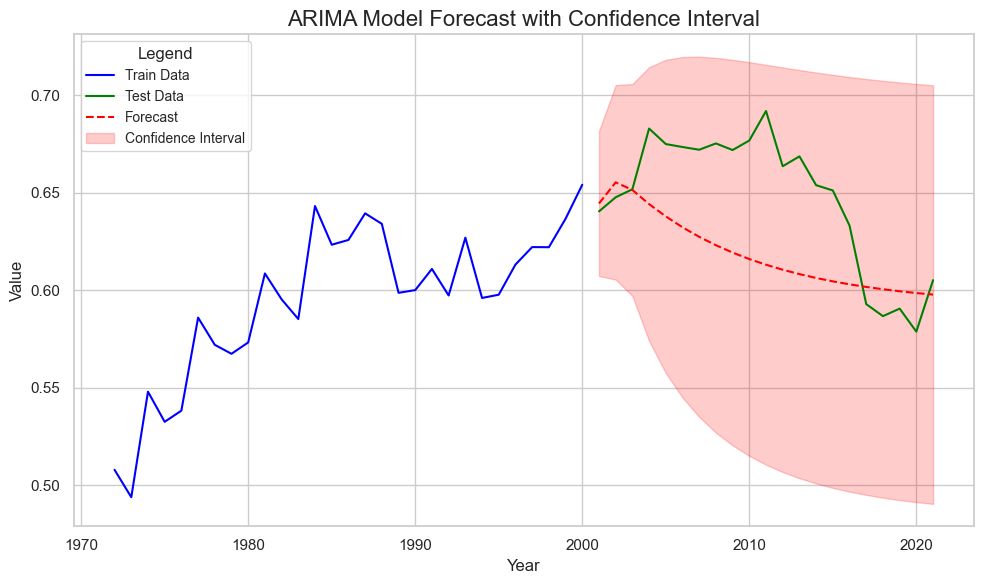

In [71]:
time_series_analysis(energy_train, energy_test)